# Natural disaster image detection 



In [1]:
import os, sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow import keras 
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt 
# !pip install opencv-python --ignore-installed --quiet
import PIL
from PIL import Image

In [3]:
print("Open CV ver: ",cv2.__version__)
print("Numpy ver: ",np.__version__)
print("Tensorflow/Keras ver:",tf.__version__)
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))


Open CV ver:  4.5.2
Numpy ver:  1.18.5
Tensorflow/Keras ver: 2.5.0
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Load images 

Using PIL to load and modify size of the pictures 

Height: 360,
 Width: 203


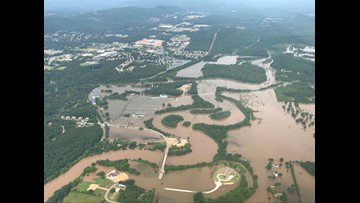

In [4]:
data = Image.open('img-data/train/flood/5.jpg').convert('RGB')
(h, w) = data.size
print("Height: {},\n Width: {}".format( h, w))
display(data)

# box = (400, 400, 1000, 1000)
# cropped_ = data.crop(box).convert('RGB')
r, g, b = data.split()

In [5]:
# store filenames in list
# flood_img_list = [ f'{flood_path}{file}' for file in os.listdir(flood_path) ]

# # read image in 1 (color); using 0 gives grayscale 
# img = cv2.imread(flood_img_list[0],1)

# # image in rgb
# img2 = img[:,:,::-1]
# print("shape of image: ",img.shape)
# plt.imshow(img2)

In [6]:
# # blue, green and red pixels 
# b, g, r = cv2.split(img)
# # height, width and number of channels 
# h, w, ch = img.shape

# # b, g, r values in the empty array to create three different versions of the image with respective channels.
# rgb_split = np.empty([h, w * 3, 3], 'uint8')
# rgb_split[:, 0:w] = cv2.merge([b, b, b])
# rgb_split[:, w: w * 2] = cv2.merge([g, g, g])
# rgb_split[:, w * 2: w * 3] = cv2.merge([r, r, r])
# plt.figure(figsize=(20,20))
# plt.imshow(rgb_split)

In [8]:

# Load the data 

TRAINING_DIR = 'img-data/train/'
VALIDATION_DIR = 'img-data/validation'

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range= 40,
                                      width_shift_range= .2,
                                      height_shift_range= .2,
                                      shear_range= .2,
                                      zoom_range= .2,
                                      horizontal_flip= True)


validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(150,150),
                                                       class_mode='categorical',
                                                       batch_size=20
                                                      )

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size=(150,150),
                                                              class_mode='categorical', 
                                                              batch_size=20
                                                             )

es = keras.callbacks.EarlyStopping(monitor='val_acc', 
                   mode='max', 
                   verbose=1, 
                   patience=6)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', 
                     monitor='val_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [9]:
train_num_of_images = train_generator.samples
batch_size = train_generator.batch_size 
print("Number of Images in training dataset: ",train_num_of_images)
print("Batch size: ",batch_size)
print('\n\nCheck on size of data/label batches:')
for data_batch, label_batch in train_generator:
    print('data batch size:', data_batch.shape)
    print('label batch size:', label_batch.shape)
    break

Number of Images in training dataset:  1600
Batch size:  20


Check on size of data/label batches:
data batch size: (20, 150, 150, 3)
label batch size: (20, 4)


In [10]:
train_generator.class_indices

{'cyclone': 0, 'earthquake': 1, 'flood': 2, 'wildfire': 3}

In [11]:
# MODEL_PATH = '/saved_model/best_model.h5'
# model_exists = os.path.exists(MODEL_PATH)
# if model_exists:
#     model = model.load(MODEL_PATH)
# else:
model = models.Sequential([layers.Conv2D(64, 
                                         (3,3), 
                                         activation='relu', 
                                         input_shape=(150,150,3)),
                          layers.MaxPool2D(2,2),
                          layers.Conv2D(128, (3,3), activation='relu'),
                          layers.MaxPool2D(2,2), 
                          layers.Conv2D(128, (3,3), activation='relu'),
                          layers.MaxPool2D(2,2),
                          layers.Flatten(),
                          layers.Dense(256, activation='relu'),
                          layers.Dense(4, activation='softmax')
                          ])



model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.summary()

history = model.fit(train_generator, 
                    epochs=100, 
                    steps_per_epoch=np.floor(train_num_of_images / batch_size), 
                    validation_data = validation_generator, 
                    verbose = 1, 
                    validation_steps=3
                   )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

Epoch 47/100
80/80 [==============================] - 39s 491ms/step - loss: 0.3915 - accuracy: 0.8550 - val_loss: 0.3928 - val_accuracy: 0.8333
Epoch 48/100
80/80 [==============================] - 39s 496ms/step - loss: 0.3657 - accuracy: 0.8625 - val_loss: 0.4749 - val_accuracy: 0.8833
Epoch 49/100
80/80 [==============================] - 39s 495ms/step - loss: 0.3783 - accuracy: 0.8631 - val_loss: 0.4818 - val_accuracy: 0.8667
Epoch 50/100
80/80 [==============================] - 40s 501ms/step - loss: 0.3725 - accuracy: 0.8631 - val_loss: 0.4950 - val_accuracy: 0.8000
Epoch 51/100
80/80 [==============================] - 40s 503ms/step - loss: 0.3630 - accuracy: 0.8694 - val_loss: 0.5379 - val_accuracy: 0.8333
Epoch 52/100
80/80 [==============================] - 39s 487ms/step - loss: 0.3537 - accuracy: 0.8700 - val_loss: 0.3635 - val_accuracy: 0.8667
Epoch 53/100
80/80 [==============================] - 40s 488ms/step - loss: 0.3480 - accuracy: 0.8719 - val_loss: 0.4706 - val_ac

In [12]:
# Save model
# if model_exists:
#     model.save('saved_models/best_model.h5')
# else:
#     !mkdir saved_models
model.save('saved_models/best_model.h5')

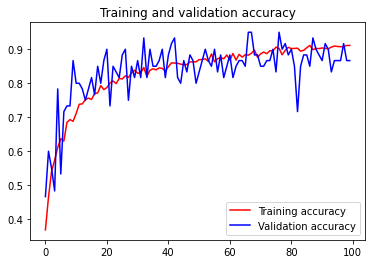

<Figure size 432x288 with 0 Axes>

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [15]:
TEST_DIR = 'img-data/test'
testing_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = testing_datagen.flow_from_directory(TEST_DIR,
                                                     target_size=(150,150),
                                                     batch_size=1)
loss_test, acc_test = model.evaluate(
    test_generator
)

print('\nThe accuracy of the model is:', str(np.round(acc_test, 2)*100),
      '% for loss value',
      str(np.round(loss_test, 2)*100),'%.')


Found 400 images belonging to 4 classes.
400/400 [==============================] - 6s 16ms/step - loss: 0.4880 - accuracy: 0.8475

The accuracy of the model is: 85.0 % for loss value 49.0 %.


Looks like our current model is able to classify images with 85% accuracy with a loss value of 49%   